# CSV Transcrip Analysis

In [ ]:

import pandas as pd
import pandas_gbq
import vertexai
from vertexai.generative_models import GenerativeModel
import google.generativeai as genai
from google.cloud import bigquery
from google.api_core.exceptions import NotFound
import json
import random
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime, timedelta




In [ ]:
# TRANCRIPT_KEYWORDS_PROMPT = """
# Act as an expert NLP Analyst. Analyze the provided transcript and extract topics.
# Parameters:
# - Product: {product}
# - Conversation ID: {conversation_id}
# - Language Code: {language_code}
# - Transcript: {transcript}

# Output ONLY a JSON array of objects with keys: conversation_id, topic, keywords, summary, sentiment.
# """

TRANCRIPT_KEYWORDS_PROMPT = """
Act as an expert NLP Analyst. Analyze the provided transcript and extract topics.
Parameters:
- Product: {product}
- Conversation ID: {conversation_id}
- Language Code: {language_code}
- Transcript: {transcript}

Main Task:
1. keywords: Try to identify from the Transcript a group of keywords that better identifies what the conversation it's about, considering general transformations like removing stopwords, removing special characters, standarizing UPPER and lower case words.
2. sentimet: identify whith which sentiment the conversation could be identify between (Positive/Neutral/Negative)

Output ONLY a JSON array of objects with keys: conversation_id, topic, keywords, summary, sentiment.
"""

In [ ]:
# ==========================================
# 1. CONFIGURATION & NAMING STANDARDS
# ==========================================

PROJECT_ID = "project-nirvana-405904"  # <--- REPLACE THIS
LOCATION = "us-central1"

PROJECT_TAG = "csv"
SCRIPT_VERSION = "001"
TABLE_VERSION = "001"

JSONL_FILE = f"vel_{PROJECT_TAG}_transcript_analysis_{SCRIPT_VERSION}.jsonl"
DATASET_ID = f"vel_{PROJECT_TAG}_schema"
TABLE_ID = f"vel_{PROJECT_TAG}_transcript_analysis_{TABLE_VERSION}"

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)
model = GenerativeModel("gemini-2.5-flash")

In [ ]:
# Function to get signals
def get_transcript_signals(df):
    """
    Creates a Gemina agent and process a DF with transctiptions and returns

    a DF with the extracted signals.
    """

    all_signals = []

    # 1. Going over the DataFrame
    for index, row in df.iterrows():
        # Formatear el prompt con los datos de la fila actual
        prompt_filled = TRANCRIPT_KEYWORDS_PROMPT.format(
            product=row['product_topic'],
            conversation_id=row['conversation_id'],
            language_code=row['language_code'],
            transcript=row['raw_transcript']
        )

        try:
            # 3. Agent Call
            response = model.generate_content(prompt_filled)

            # Cleaning the response (deleting markdown if exists)
            clean_json = re.sub(r'```json|```', '', response.text).strip()

            # 4. Parsing JSON to obtain results
            data = json.loads(clean_json)

            # If the model returns a list, it is extended
            if isinstance(data, list):
                all_signals.extend(data)
            else:
                all_signals.append(data)

        except Exception as e:
            print(f"Error procesando la conversación {row['conversation_id']}: {e}")
            continue

    # 5. Resultes are returned on a DataFrame
    return pd.DataFrame(all_signals)


In [ ]:
# Retreiving Synthetic Data
project_id = 'project-nirvana-405904'
table_name = 'project-nirvana-405904.vel_csv_schema.vel_csv_synthetic_transcripts_003'
columns = ['product_topic', 'raw_transcript', 'language_code', 'conversation_id']

query = f"SELECT {', '.join(columns)} FROM `{table_name}`"

df = pandas_gbq.read_gbq(query, project_id=project_id)

Downloading: 100%|██████████|


In [ ]:
res_df = get_transcript_signals(df)
res_df.head()

,conversation_id,topic,keywords,summary,sentiment
0,7_1_1770926034,YouTube Ad Revenue Explanation: RPM vs CPM,"[ad revenue, monetization, youtube analytics, ...",The conversation addresses a Creator's concern...,Neutral
1,22_0_1770926659,Understanding AdSense RPM vs. CPM in the conte...,"[adsense, rpm, cpm, youtube partner program, y...","The creator, ProVerse, contacted the YouTube P...",Positive
2,25_1_1770926821,AdSense RPM vs CPM,"[adsense, rpm, cpm, earnings, revenue, metrics...",The conversation focuses on clarifying the dif...,Negative
3,53_0_1770928091,AdSense RPM vs CPM for YouTube Shorts and Iden...,"[adsense rpm, cpm, youtube shorts, monetizatio...",A YouTube Partner Program Manager (SPM) discus...,Positive
4,60_0_1770928430,AdSense RPM vs CPM and Creator Earnings,"[adsense, rpm, cpm, revenue, earnings, monetiz...",This quarterly business review between YouTube...,Positive


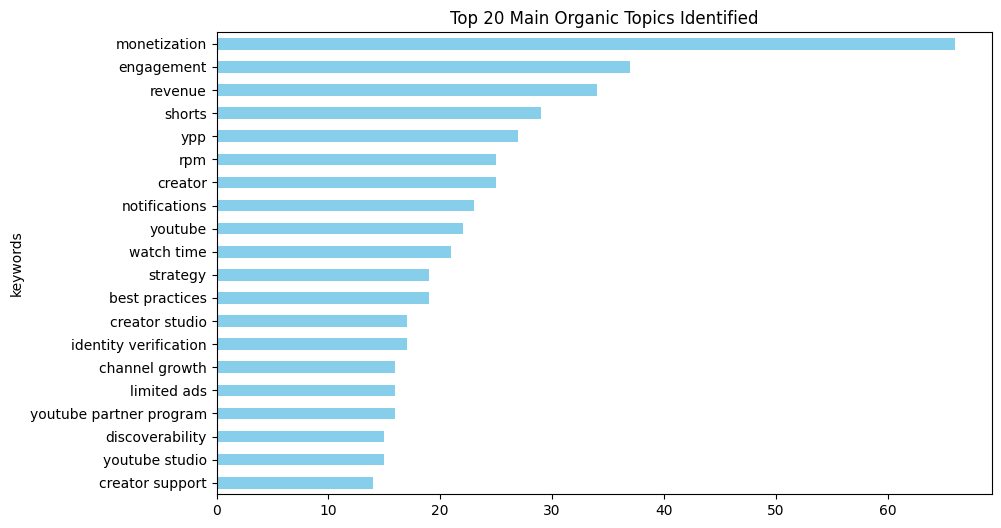

In [ ]:
# Top 10 Signals
plt.figure(figsize=(10,6))
res_df.explode('keywords')['keywords'].value_counts().head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Main Organic Topics Identified')
plt.gca().invert_yaxis()
plt.show()

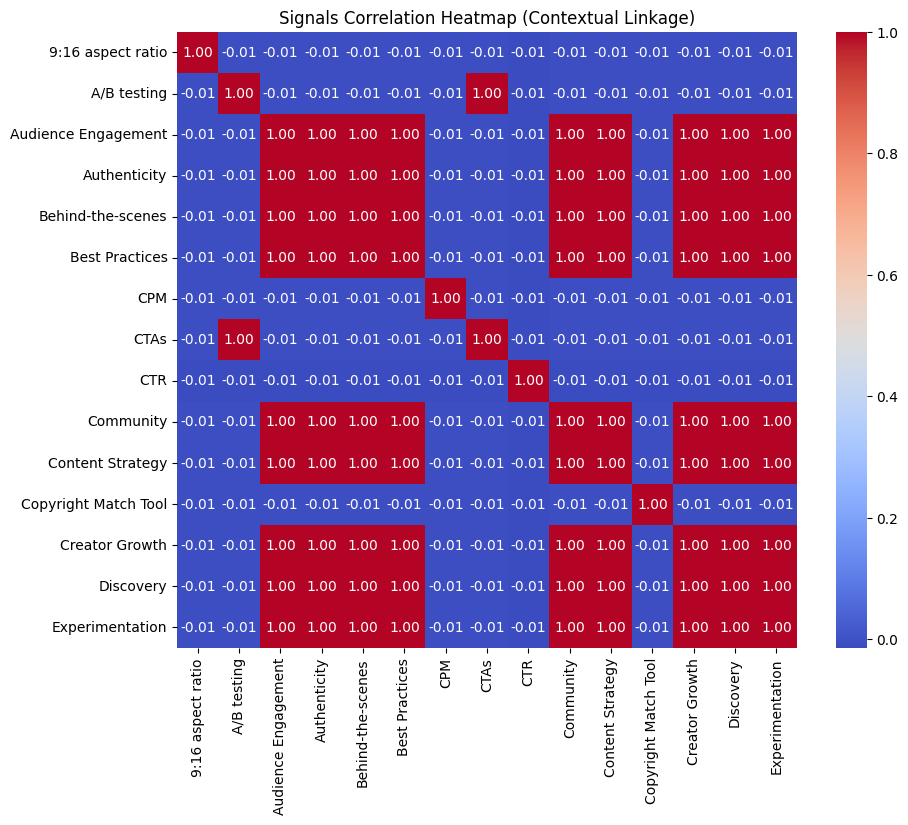

In [ ]:
# Creating a matrix where every column is a keyword and every row is a
# conversation
mlb = MultiLabelBinarizer()
co_occurrence_matrix = mlb.fit_transform(res_df['keywords'])
df_cooc = pd.DataFrame(co_occurrence_matrix, columns=mlb.classes_)

# Calculating correlation between words
correlation_matrix = df_cooc.corr()

# Showing a subset of the most important keywords
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.iloc[:15, :15], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Signals Correlation Heatmap (Contextual Linkage)')
plt.show()

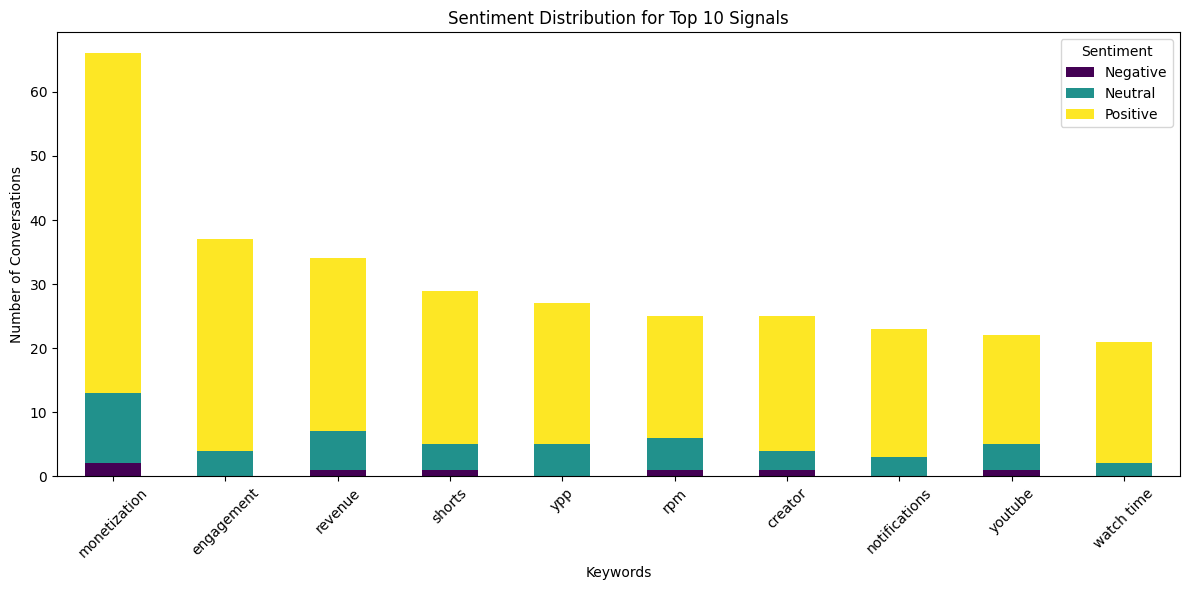

In [ ]:
# 1. Exploding the keyword field so every keyword could have its own row
df_exploded = res_df.explode('keywords')

# 2. Basic cleansing to avoid duplicates, spaces and uppercase words
df_exploded['keywords'] = df_exploded['keywords'].astype(str).str.strip()

# 3. Identifyin Top 10 frecuent words
top_keys = df_exploded['keywords'].value_counts().head(10).index

# 4. Grouping by keyword and sentiment
keyword_sentiment = df_exploded.groupby(['keywords', 'sentiment']).size().unstack().fillna(0)

# 5. Filtering matrix by keywords
keyword_sentiment.loc[top_keys].plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')

plt.title('Sentiment Distribution for Top 10 Signals')
plt.xlabel('Keywords')
plt.ylabel('Number of Conversations')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

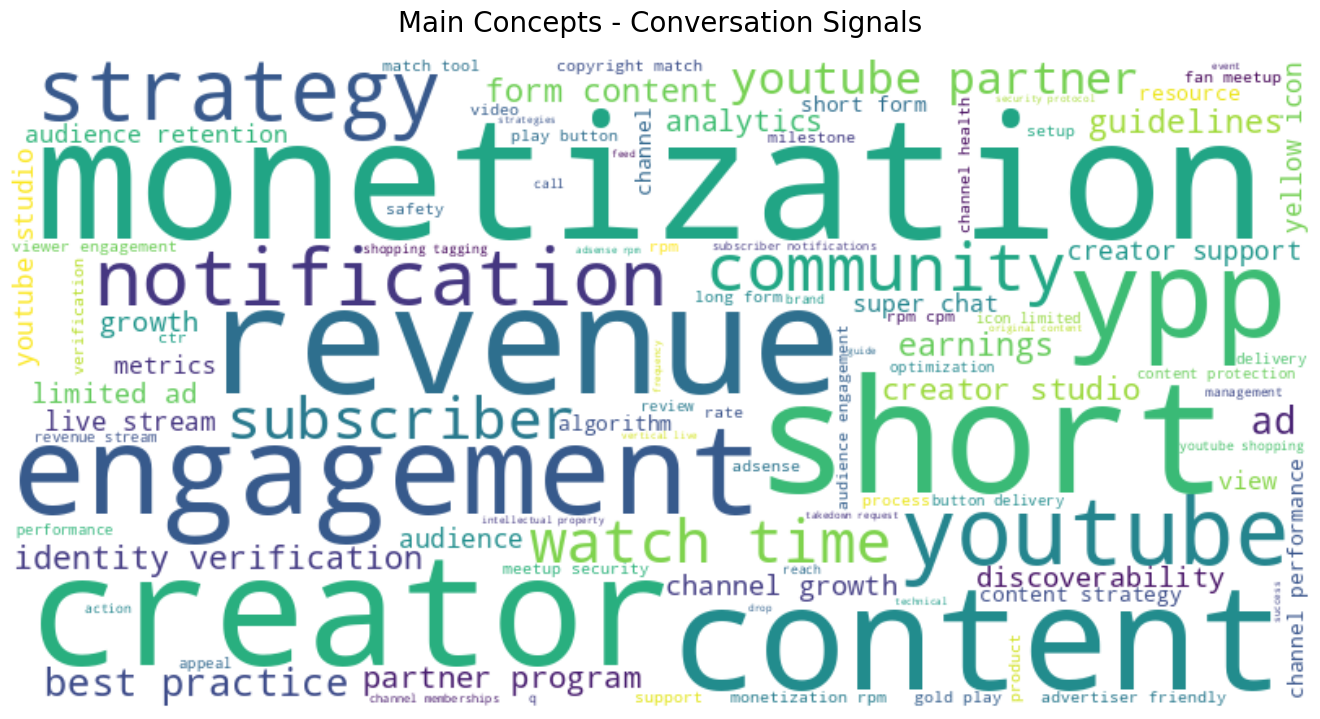

In [ ]:
# 1. We "exploit" and clean the words to have a flat list of strings.
# This ensures that each keyword is treated individually.
all_keywords = res_df.explode('keywords')['keywords'].astype(str).str.strip()

# 2. We combine all the keywords into a single giant string separated by spaces.
# (The word cloud will count the frequency of each word in this string)
text_for_cloud = " ".join(all_keywords)

# 3. We configured and generated the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100,           # Limit to 100 most important words
    contour_width=3,
    contour_color='steelblue'
).generate(text_for_cloud)

# 4. Showing the results
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')

# Removing axes
plt.axis('off')

plt.title('Main Concepts - Conversation Signals', fontsize=20, pad=20)
plt.tight_layout(pad=0)
plt.show()

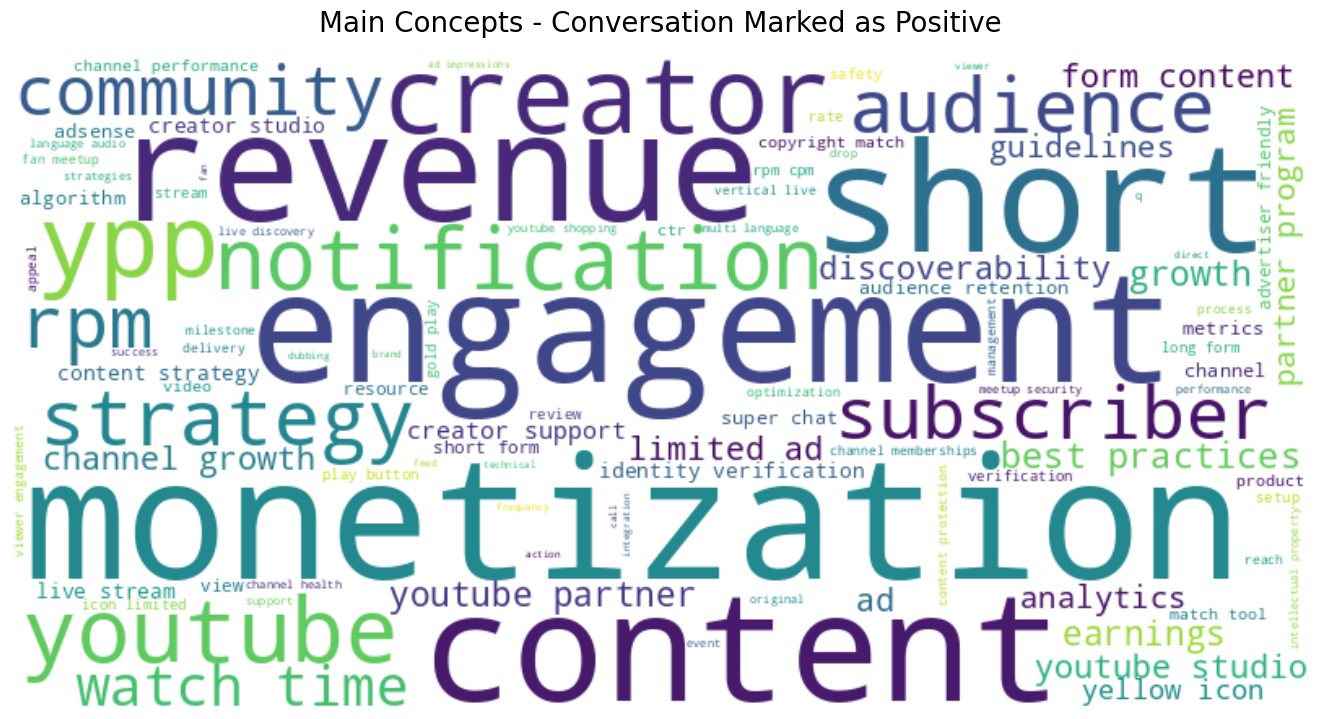

In [ ]:
# 1. We "exploit" and clean the words to have a flat list of strings.
# This ensures that each keyword is treated individually.
f_df = res_df[res_df['sentiment']=='Positive']
all_keywords = f_df.explode('keywords')['keywords'].astype(str).str.strip()

# 2. We combine all the keywords into a single giant string separated by spaces.
# (The word cloud will count the frequency of each word in this string)
text_for_cloud = " ".join(all_keywords)

# 3. We configured and generated the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100,           # Limit to 100 most important words
    contour_width=3,
    contour_color='steelblue'
).generate(text_for_cloud)

# 4. Showing the results
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')

# Removing axes
plt.axis('off')

plt.title('Main Concepts - Conversation Marked as Positive', fontsize=20, pad=20)
plt.tight_layout(pad=0)
plt.show()

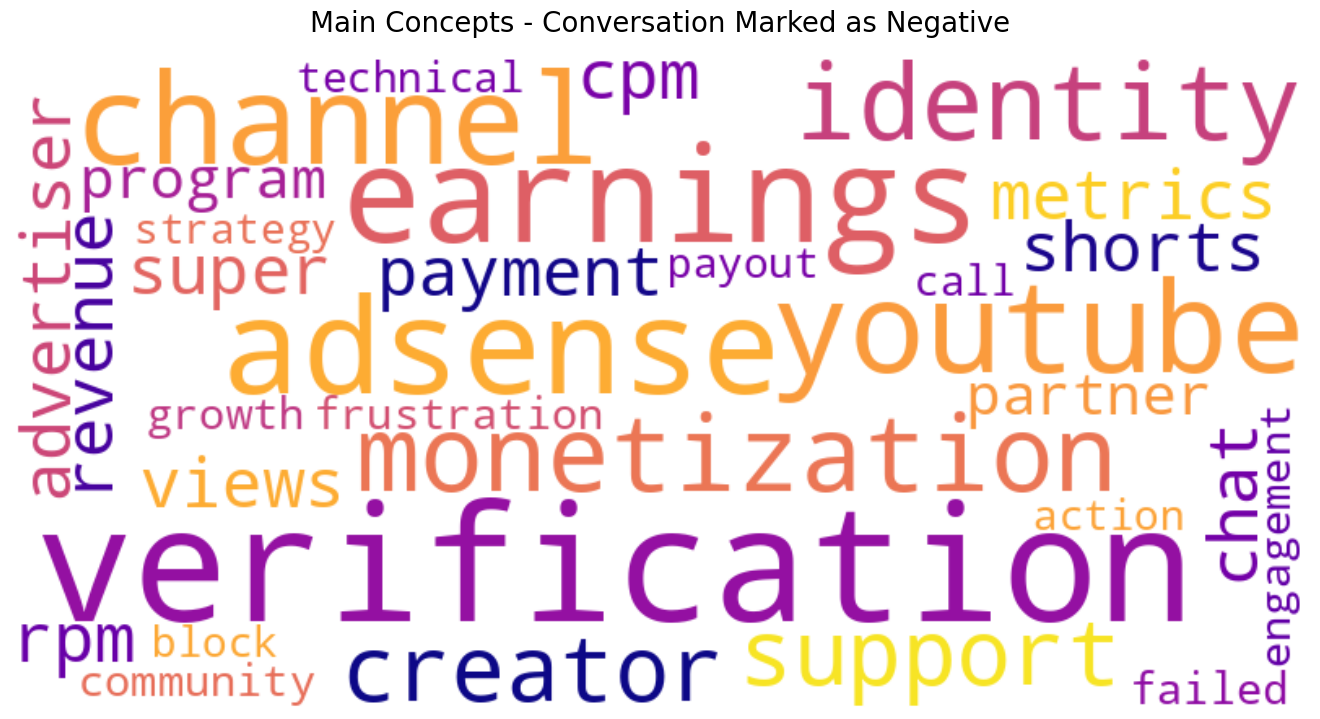

In [ ]:
# 1. We "exploit" and clean the words to have a flat list of strings.
# This ensures that each keyword is treated individually.
f_df = res_df[res_df['sentiment']=='Negative']
all_keywords = f_df.explode('keywords')['keywords'].astype(str).str.strip()

# 2. We combine all the keywords into a single giant string separated by spaces.
# (The word cloud will count the frequency of each word in this string)
text_for_cloud = " ".join(all_keywords)

# 3. We configured and generated the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='plasma',
    max_words=100,           # Limit to 100 most important words
    contour_width=3,
    contour_color='steelblue'
).generate(text_for_cloud)

# 4. Showing the results
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')

# Removing axes
plt.axis('off')

plt.title('Main Concepts - Conversation Marked as Negative', fontsize=20, pad=20)
plt.tight_layout(pad=0)
plt.show()